In [1]:
cd ..

/Users/abhi/Documents/GitHub/AQT-KimGroup


In [4]:
from keys import keys
from qiskit import IBMQ, assemble, QuantumCircuit, quantum_info
from qiskit.visualization import plot_histogram
import numpy as np

%matplotlib inline

In [5]:
# Setup account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# Find available devices
devices = provider.backends(simulator=True, operational=True)
for x in devices:
    print(x.name(), x.configuration().n_qubits, x.status().pending_jobs)

ibmq_qasm_simulator 32 1
simulator_statevector 32 1
simulator_mps 100 1
simulator_extended_stabilizer 63 1
simulator_stabilizer 5000 1


In [6]:
simulator_backend = provider.backend.ibmq_qasm_simulator

Test the ordering or endian-ness of the Qiskit results - only ran to determine that unline qml, we need to read circuits from bottom-to-top

     ┌───┐┌─┐
q_0: ┤ H ├┤M├
     └┬─┬┘└╥┘
q_1: ─┤M├──╫─
      └╥┘  ║ 
c: 2/══╩═══╩═
       1   0 


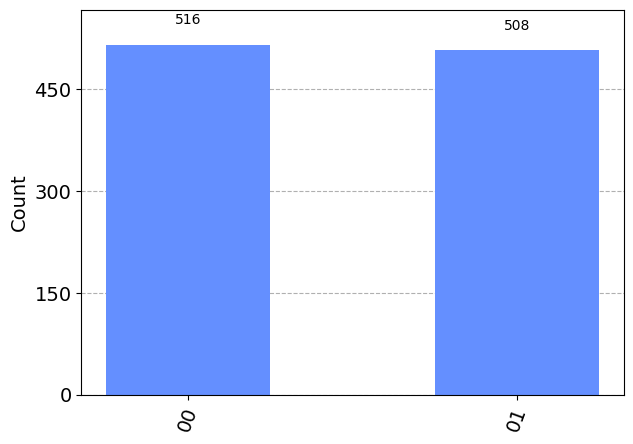

In [12]:
# No. of qubits
n_qubits = 2

# Initialize the quantum register and circuit
circ = QuantumCircuit(n_qubits, n_qubits)

# Add operations to the circuit to prepage a GHZ state
circ.h(0)
circ.measure([0, 1], [0, 1])
print(circ.draw())

# Simple qiskit running
qobj = assemble(circ)  # Assemble circuit into a Qobj that can be run
counts = simulator_backend.run(qobj).result().get_counts()  # Do the simulation, returning the state vector
plot_histogram(counts)

Reproducing Qiskit MLE


The following was part of the old notebook but is now deprecated in qiskit - 
`from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter`

In [7]:
from qiskit_experiments.library import StateTomography, tomography

In [25]:
# Setup system

# No. of qubits
n_qubits = 3
n_shots = 100

In [18]:
# Initialize the quantum register and circuit
ghz_circ = QuantumCircuit(n_qubits)

# Add operations to the circuit to prepage a GHZ state
ghz_circ.h(0)
for idx in range(n_qubits-1):
    ghz_circ.cx(idx, idx+1)

ghz_circ.draw()

┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

In [19]:
qst_exp = StateTomography(ghz_circ)
qst_data_1 = qst_exp.run(simulator_backend, seed_simulation=100, shots=n_shots).block_for_results()
for circuit in qst_exp.circuits():
    print(circuit.draw())

     ┌───┐           ░ ┌────────────┐ ░ ┌─┐      
q_0: ┤ H ├──■────────░─┤ PauliMeasZ ├─░─┤M├──────
     └───┘┌─┴─┐      ░ ├────────────┤ ░ └╥┘┌─┐   
q_1: ─────┤ X ├──■───░─┤ PauliMeasZ ├─░──╫─┤M├───
          └───┘┌─┴─┐ ░ ├────────────┤ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░─┤ PauliMeasZ ├─░──╫──╫─┤M├
               └───┘ ░ └────────────┘ ░  ║  ║ └╥┘
c: 3/════════════════════════════════════╩══╩══╩═
                                         0  1  2 
     ┌───┐           ░ ┌────────────┐ ░ ┌─┐      
q_0: ┤ H ├──■────────░─┤ PauliMeasZ ├─░─┤M├──────
     └───┘┌─┴─┐      ░ ├────────────┤ ░ └╥┘┌─┐   
q_1: ─────┤ X ├──■───░─┤ PauliMeasZ ├─░──╫─┤M├───
          └───┘┌─┴─┐ ░ ├────────────┤ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░─┤ PauliMeasX ├─░──╫──╫─┤M├
               └───┘ ░ └────────────┘ ░  ║  ║ └╥┘
c: 3/════════════════════════════════════╩══╩══╩═
                                         0  1  2 
     ┌───┐           ░ ┌────────────┐ ░ ┌─┐      
q_0: ┤ H ├──■────────░─┤ PauliMeasZ ├─░─┤M├──────


Following the introduction to the experiment framework at `https://qiskit.org/documentation/experiments/apidocs/framework.html#module-qiskit_experiments.framework`

In [22]:
qst_data_1.job_ids

['63917e17d26abd301725ac8b']

In [23]:
job = simulator_backend.retrieve_job('63917e17d26abd301725ac8b')
result = job.result()

In [ ]:
# Saved experiments
# 3 qubit GHZ - 6390ffde5252115aa3e127c1 - 1024 shots
# 3 qubit GHZ - 63917e17d26abd301725ac8b - 100 shots

In [27]:
n_sets = 3**n_qubits
for i in range(n_sets):
    print(result.results[i].header.name.split('_')[1][1:-1].split(', '), result.get_counts(i))

['0', '0', '0'] {'000': 47, '111': 53}
['0', '0', '1'] {'000': 27, '011': 26, '100': 26, '111': 21}
['0', '0', '2'] {'000': 24, '011': 28, '100': 24, '111': 24}
['0', '1', '0'] {'000': 26, '010': 26, '101': 28, '111': 20}
['0', '1', '1'] {'000': 10, '001': 11, '010': 13, '011': 10, '100': 15, '101': 16, '110': 12, '111': 13}
['0', '1', '2'] {'000': 8, '001': 10, '010': 10, '011': 12, '100': 11, '101': 17, '110': 14, '111': 18}
['0', '2', '0'] {'000': 25, '010': 33, '101': 22, '111': 20}
['0', '2', '1'] {'000': 13, '001': 16, '010': 9, '011': 15, '100': 14, '101': 11, '110': 15, '111': 7}
['0', '2', '2'] {'000': 13, '001': 10, '010': 13, '011': 9, '100': 15, '101': 14, '110': 16, '111': 10}
['1', '0', '0'] {'000': 21, '001': 31, '110': 24, '111': 24}
['1', '0', '1'] {'000': 15, '001': 16, '010': 11, '011': 12, '100': 11, '101': 8, '110': 17, '111': 10}
['1', '0', '2'] {'000': 11, '001': 16, '010': 11, '011': 7, '100': 13, '101': 16, '110': 11, '111': 15}
['1', '1', '0'] {'000': 8, '001'

By comparing the above expt. header names, with the circuits, it is clear to see the mapping Z -> 0, X -> 1, Y -> 2. This is similar to what was previously being used in the deprecated library. Now, we need to convert the readouts to POVM outcomes.

In [32]:
data = np.zeros((n_sets*n_shots, n_qubits), dtype=int)
idx = 0

for n_set in range(n_sets):
    # Raw measurement counts for 1 experiment e.g. {'000':X, '111':Y}
    counts_dict = result.get_counts(n_set)
    
    # Measurement setup e.g. ['0', '0', '0'] -> [Z, Z, Z]
    meas_setting = result.results[n_set].header.name.split('_')[1][1:-1].split(', ')
    meas_setting.reverse()
    
    for bitstring, count in counts_dict.items():
        # Map the projective outcomes to POVM outcomes
        # e.g. given setting [100], map outcome [000] to [200] and [100] to [300]
        outcome = np.array([2*int(meas_setting[i]) + int(bitstring[i]) for i in range(3)])
        data[idx:idx+count] = outcome
        idx += count

print(idx, len(data))

2700 2700


In [35]:
print(data[126:128])

[[2 0 0]
 [2 1 1]]
